# Tarea 7 - Luis Enrique López Nerio 1487280

Para la realizacion de esta tarea se realiza la clasificacion de vegetales utilizando transferencia de aprendizaje utilizando los pesos de la red neuronal de InceptionV3

In [25]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from PIL import Image 
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt

import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout

Primero definimos algunos constantes como los tamaños de las imagenes, epochs y directorio base de las imagenes

In [11]:
BASE_URL='..\\Tarea 6\\Vegetable Images'

train_folder = os.path.join(BASE_URL,"train")
validation_folder = os.path.join(BASE_URL,"validation")
test_folder = os.path.join(BASE_URL,"test")

Realizamos las modificaciones necesarias para el procesamiento del modelo utilizando InceptionV3, una de las modificaciones mas notables es el ajuste de la capa de salida, ya que esta es de 15 clasificaciones en nuestro caso

In [4]:
IMAGE_SIZE = [224, 224]

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False

x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

prediction = Dense(15, activation='softmax')(x)

model = Model(inputs=inception.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

87924736/87910968 [==============================] - 8s 0us/step


Leemos las imagenes de entrenamiento y prueba

In [5]:
train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(
    train_folder,
    target_size = (224, 224),
    batch_size = 64,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    test_folder, 
    target_size = (224, 224),
    batch_size = 64, 
    class_mode = 'categorical')

Found 15001 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [6]:
class_map = training_set.class_indices
class_map

{'Bean': 0,
 'Bitter_Gourd': 1,
 'Bottle_Gourd': 2,
 'Brinjal': 3,
 'Broccoli': 4,
 'Cabbage': 5,
 'Capsicum': 6,
 'Carrot': 7,
 'Cauliflower': 8,
 'Cucumber': 9,
 'Papaya': 10,
 'Potato': 11,
 'Pumpkin': 12,
 'Radish': 13,
 'Tomato': 14}

Entrenamos el model para la transferencia de aprendizaje

In [7]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/5
235/235 [==============================] - 199s 788ms/step - loss: 0.2660 - accuracy: 0.9207 - val_loss: 0.0426 - val_accuracy: 0.9893
Epoch 2/5
235/235 [==============================] - 149s 634ms/step - loss: 0.0722 - accuracy: 0.9777 - val_loss: 0.0270 - val_accuracy: 0.9933
Epoch 3/5
235/235 [==============================] - 148s 631ms/step - loss: 0.0496 - accuracy: 0.9841 - val_loss: 0.0306 - val_accuracy: 0.9900
Epoch 4/5
235/235 [==============================] - 150s 638ms/step - loss: 0.0393 - accuracy: 0.9872 - val_loss: 0.0179 - val_accuracy: 0.9937
Epoch 5/5
235/235 [==============================] - 152s 644ms/step - loss: 0.0314 - accuracy: 0.9909 - val_loss: 0.0158 - val_accuracy: 0.9950


In [8]:
model.save('transfer_learning_model.h5')

Mostramos las curvas de precision y de perdida a lo largo de los epochs.

Algo que se puede notar es como poco a poco el acurracy va en aumento al igual que la perdida se reduce.

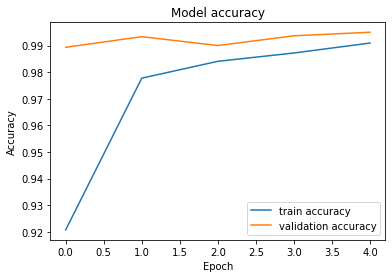

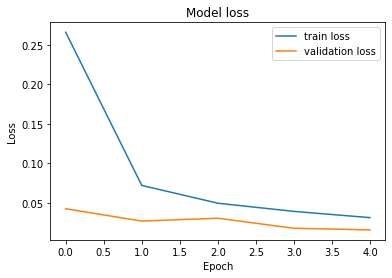

In [9]:
def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()
    
plot_accuracy(r)
plot_loss(r)

In [10]:
K.clear_session()
path_to_model='./transfer_learning_model.h5'
print("Loading the model..")
model = load_model(path_to_model)
print("Done!")

Loading the model..
Done!


En base al modelo generado vamos a compararlo con los datos de validacion. Para esto leeremos las imagenes de validacion y finalmente veremos el resultado final en una matriz de confusion.

In [12]:
validation_datagen = image.ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_folder,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical')

scores = model.evaluate_generator(validation_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

Found 3000 images belonging to 15 classes.
Test Accuracy: 0.995


In [19]:
category={
    0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3 : 'Brinjal', 4: "Broccoli", 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower',
    9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13 : "Radish", 14: "Tomato"
}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(category[index]))
    plt.imshow(img_array)
    
def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1
    
    true=filedir.split('\\')[-1]
    
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))
        
    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
                
        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))

In [20]:
for i in os.listdir(validation_folder):
    predict_dir(os.path.join(validation_folder,i),model)

Accuracy for Bean: 1.00 (200/200)
Accuracy for Bitter_Gourd: 1.00 (200/200)
Accuracy for Bottle_Gourd: 0.99 (198/200)
Accuracy for Brinjal: 0.98 (196/200)
Accuracy for Broccoli: 1.00 (200/200)
Accuracy for Cabbage: 1.00 (200/200)
Accuracy for Capsicum: 1.00 (200/200)
Accuracy for Carrot: 0.99 (198/200)
Accuracy for Cauliflower: 1.00 (200/200)
Accuracy for Cucumber: 0.99 (199/200)
Accuracy for Papaya: 0.98 (196/200)
Accuracy for Potato: 1.00 (200/200)
Accuracy for Pumpkin: 0.99 (199/200)
Accuracy for Radish: 0.99 (199/200)
Accuracy for Tomato: 1.00 (200/200)


In [23]:
def labels_confusion_matrix(validation_folder):
    
    folder_path=validation_folder
    
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):
        
        true=os.path.join(folder_path,i)
        true=true.split('\\')[-1]
        true=mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(224,224))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 15
    cmap="turbo"
    cm_plot_labels = [i for i in range(15)]
    
    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) # for label size
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) # font size

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

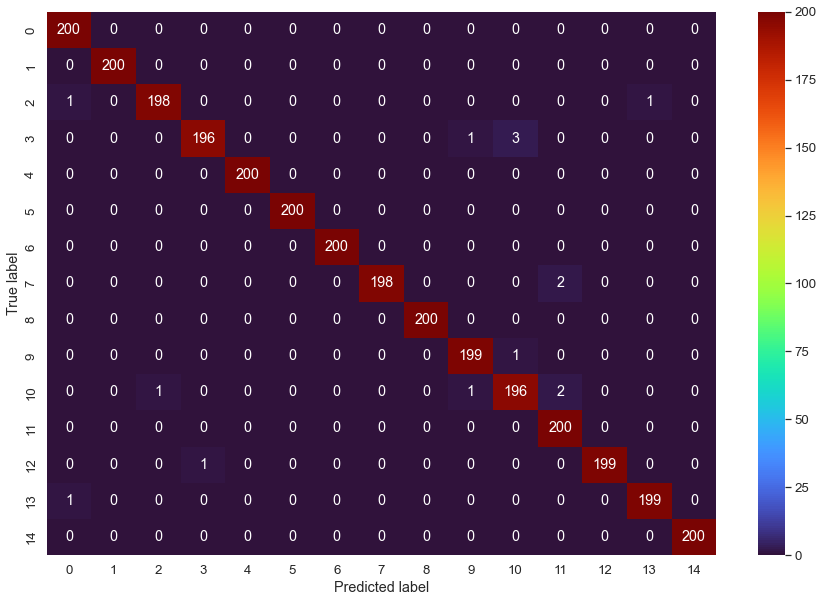

In [24]:
y_true,y_pred=labels_confusion_matrix(validation_folder)
print_confusion_matrix(y_true,y_pred)

In [26]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

np.count_nonzero(y_pred == y_true) / len(y_pred)

0.995

## Conclusion

El uso de transferencia de aprendizaje nos dio un resultado mejor que el utilizar una arquitectura en base a Alexnet. Aunque los resultados son muy similares se obtuvo una mejora en comparacion al 98% de precision obtenidos para la tarea anterior.